# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

# 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [2]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [3]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [4]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [5]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [6]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [7]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [8]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [10]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1460 - val_loss: 0.9468
Epoch 2/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1433 - val_loss: 0.9449
Epoch 3/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1406 - val_loss: 0.9431
Epoch 4/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1381 - val_loss: 0.9413
Epoch 5/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1357 - val_loss: 0.9396
Epoch 6/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1332 - val_loss: 0.9379
Epoch 7/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1308 - val_loss: 0.9362
Epoch 8/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1284 - val_loss: 0.9345
Epoch 9/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1260 - val_loss: 0.9329
Epoch 10/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.123

149/149 [==============================] - 0s 1ms/step - loss: 0.9835 - val_loss: 0.8362
Epoch 81/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9817 - val_loss: 0.8350
Epoch 82/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9800 - val_loss: 0.8338
Epoch 83/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9783 - val_loss: 0.8327
Epoch 84/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9766 - val_loss: 0.8315
Epoch 85/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9749 - val_loss: 0.8303
Epoch 86/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9732 - val_loss: 0.8291
Epoch 87/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9715 - val_loss: 0.8279
Epoch 88/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9698 - val_loss: 0.8268
Epoch 89/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9682 - v

149/149 [==============================] - 0s 1ms/step - loss: 0.8620 - val_loss: 0.7486
Epoch 160/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8606 - val_loss: 0.7475
Epoch 161/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8591 - val_loss: 0.7464
Epoch 162/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8577 - val_loss: 0.7453
Epoch 163/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8562 - val_loss: 0.7442
Epoch 164/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8548 - val_loss: 0.7431
Epoch 165/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8533 - val_loss: 0.7420
Epoch 166/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8519 - val_loss: 0.7408
Epoch 167/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8504 - val_loss: 0.7398
Epoch 168/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

Epoch 238/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7498 - val_loss: 0.6600
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7484 - val_loss: 0.6589
Epoch 240/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7470 - val_loss: 0.6578
Epoch 241/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7456 - val_loss: 0.6567
Epoch 242/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7442 - val_loss: 0.6556
Epoch 243/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7428 - val_loss: 0.6545
Epoch 244/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7414 - val_loss: 0.6534
Epoch 245/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7400 - val_loss: 0.6523
Epoch 246/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7386 - val_loss: 0.6512
Epoch 247/1000
149/149 [==============================] - 0s 1ms

Epoch 317/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6426 - val_loss: 0.5735
Epoch 318/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6413 - val_loss: 0.5724
Epoch 319/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6400 - val_loss: 0.5714
Epoch 320/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6387 - val_loss: 0.5703
Epoch 321/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6374 - val_loss: 0.5693
Epoch 322/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6362 - val_loss: 0.5682
Epoch 323/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6349 - val_loss: 0.5672
Epoch 324/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6336 - val_loss: 0.5661
Epoch 325/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6323 - val_loss: 0.5651
Epoch 326/1000
149/149 [==============================] - 0s 1ms

Epoch 396/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5461 - val_loss: 0.4945
Epoch 397/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5450 - val_loss: 0.4936
Epoch 398/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5439 - val_loss: 0.4927
Epoch 399/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5428 - val_loss: 0.4918
Epoch 400/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5416 - val_loss: 0.4909
Epoch 401/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5405 - val_loss: 0.4899
Epoch 402/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5394 - val_loss: 0.4890
Epoch 403/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5383 - val_loss: 0.4881
Epoch 404/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5372 - val_loss: 0.4872
Epoch 405/1000
149/149 [==============================] - 0s 1ms

Epoch 475/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4654 - val_loss: 0.4276
Epoch 476/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4645 - val_loss: 0.4268
Epoch 477/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4636 - val_loss: 0.4261
Epoch 478/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4627 - val_loss: 0.4253
Epoch 479/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4618 - val_loss: 0.4245
Epoch 480/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4610 - val_loss: 0.4238
Epoch 481/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4601 - val_loss: 0.4230
Epoch 482/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4592 - val_loss: 0.4223
Epoch 483/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4583 - val_loss: 0.4215
Epoch 484/1000
149/149 [==============================] - 0s 1ms

Epoch 554/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4035 - val_loss: 0.3737
Epoch 555/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4028 - val_loss: 0.3731
Epoch 556/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4022 - val_loss: 0.3725
Epoch 557/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4015 - val_loss: 0.3719
Epoch 558/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4008 - val_loss: 0.3713
Epoch 559/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4002 - val_loss: 0.3707
Epoch 560/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3995 - val_loss: 0.3701
Epoch 561/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3989 - val_loss: 0.3695
Epoch 562/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3982 - val_loss: 0.3689
Epoch 563/1000
149/149 [==============================] - 0s 1ms

Epoch 633/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3566 - val_loss: 0.3302
Epoch 634/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3561 - val_loss: 0.3297
Epoch 635/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3556 - val_loss: 0.3292
Epoch 636/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3550 - val_loss: 0.3287
Epoch 637/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3545 - val_loss: 0.3282
Epoch 638/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3540 - val_loss: 0.3277
Epoch 639/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3535 - val_loss: 0.3272
Epoch 640/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3530 - val_loss: 0.3267
Epoch 641/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3525 - val_loss: 0.3263
Epoch 642/1000
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.3215 - val_loss: 0.2958
Epoch 712/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3211 - val_loss: 0.2954
Epoch 713/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3207 - val_loss: 0.2950
Epoch 714/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3204 - val_loss: 0.2947
Epoch 715/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3200 - val_loss: 0.2943
Epoch 716/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3196 - val_loss: 0.2939
Epoch 717/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3192 - val_loss: 0.2935
Epoch 718/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3188 - val_loss: 0.2931
Epoch 719/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3184 - val_loss: 0.2927
Epoch 720/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

Epoch 790/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2943 - val_loss: 0.2681
Epoch 791/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2940 - val_loss: 0.2678
Epoch 792/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2938 - val_loss: 0.2675
Epoch 793/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2935 - val_loss: 0.2672
Epoch 794/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2932 - val_loss: 0.2669
Epoch 795/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2929 - val_loss: 0.2666
Epoch 796/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2926 - val_loss: 0.2663
Epoch 797/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2923 - val_loss: 0.2659
Epoch 798/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2920 - val_loss: 0.2656
Epoch 799/1000
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.2736 - val_loss: 0.2460
Epoch 869/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2734 - val_loss: 0.2458
Epoch 870/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2732 - val_loss: 0.2455
Epoch 871/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2729 - val_loss: 0.2452
Epoch 872/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2727 - val_loss: 0.2450
Epoch 873/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2725 - val_loss: 0.2447
Epoch 874/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2723 - val_loss: 0.2445
Epoch 875/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2720 - val_loss: 0.2442
Epoch 876/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2718 - val_loss: 0.2440
Epoch 877/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

Epoch 947/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2573 - val_loss: 0.2279
Epoch 948/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2571 - val_loss: 0.2276
Epoch 949/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2569 - val_loss: 0.2274
Epoch 950/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2567 - val_loss: 0.2272
Epoch 951/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2566 - val_loss: 0.2270
Epoch 952/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2564 - val_loss: 0.2268
Epoch 953/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2562 - val_loss: 0.2266
Epoch 954/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2560 - val_loss: 0.2264
Epoch 955/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2558 - val_loss: 0.2262
Epoch 956/1000
149/149 [==============================] - 0s 1ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

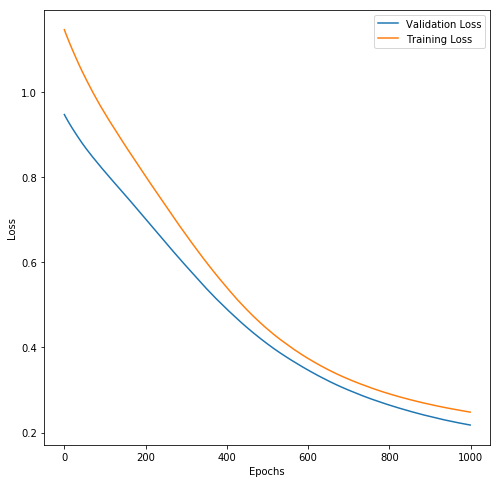

In [12]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

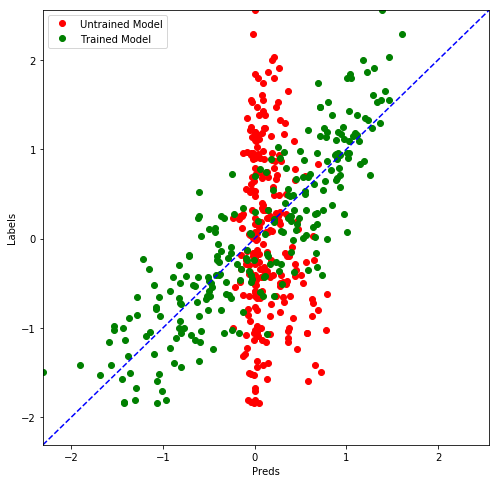

In [13]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

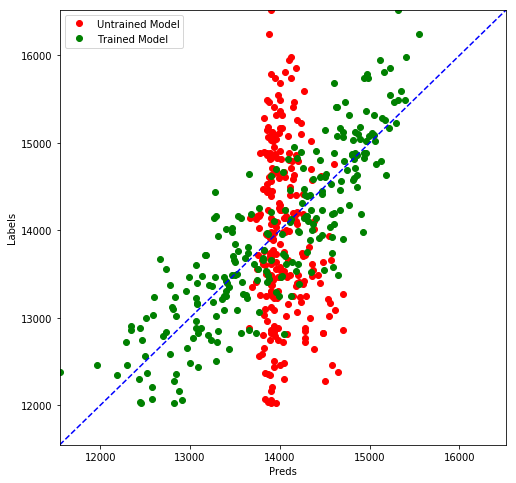

In [14]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)